# TC 3007B
# GPT 2


**Equipo Pochos Hermanos**

* Imanol Muñiz Ramirez - A01701713

* Ernesto Acosta Ruiz	- A01364982

* Gabriela Chimali Nava Ramírez	- A01710530

* Victor Adid Salgado Santana	- A01710023

* Diego Lira García	- A01710369

* Andrea Medina Rico - A01705541

* Paul Park	- A01709885

# Activity 2,3: Code GPT2

- Objective:
    - To understand the Transformer architecture.
    - To code GPT 2.
    - To gain understanding of the LLMs' autoregresive nature..

- Instructions

    This activity requires submission in teams. While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Follow the provided code. The code already implements a transformer from scratch as explained in [this video](https://youtu.be/51jq4wnHYaY)

    Since the provided code already implements a simple translator, your job for this assignment is to understand it fully, and document it using pictures, figures, and markdown cells.  
  
- Evaluation Criteria

    - Code Readability and Comments (40%).
    - Traning a LM,  complete 'Train function' (30%).
    - Generating at least 10 sentences, comple 'Sample function' (30%).

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.




## 1. Introducción

El siguiente diagrama muestra la arquitectura del transformer del paper "Attention is all you need". En este archivo, se implementa un GPT-2 con ligeras modificaciones al Transformer inicial, las cuales son explicadas a lo largo de la construcción del modelo.

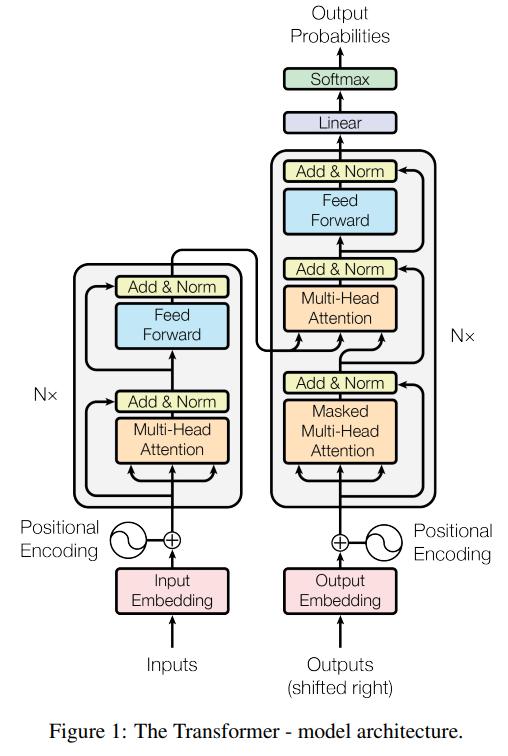

Figura 1. Arquitectura del modelo Transformer

## 2. Importe inicial

In [49]:
# Verificar versiones de las librerías
import transformers
import torch
print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")

Transformers version: 4.57.3
PyTorch version: 2.7.1+cu118


In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import torch.optim as optim

## 3. Configuración inicial de hiper parámetros

Los hiperparámetros especificados inicialmente para GPT-2 son:
* **vocab_size:** siendo |V| en la literatura, es el tamaño del vocabulario. Es decir, la cantidad de tokens únicos que existen y serán utilizados en la predicción.
* **max_sequence_length:** siendo T, es el tamaño máximo de la secuencia.
* **embed_size:** siendo D, es el tamaño del *embedding*.
* **num_layers:** número de capas del Transformer.
* **num_heads:** número de cabezas de atención. Este número debe dividir en partes iguales al tamaño del embedding.
* **dropout:** valor del dropout, designado para evitar el *overfitting* al apagar temporalmente celdas para evitar que se genere dependencia en una de estas.

In [51]:
class Config:
    '''
    Clase de configuración que almacena los hiperparámetros del modelo GPT-2.
    Los valores predeterminados son propios de GPT-2.
    '''
    def __init__(self, vocab_size = 50257, max_seq_length = 128, embed_size = 768, num_layers = 12,
                 num_heads = 12, dropout = 0.1):
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length
        self.embed_size = embed_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout = dropout

## 4. Atención

Las **Multihead Self Attention** son un aspecto clave para el GPT-2. Cada cabeza tiene tres aspectos clave: Query, Key y Value. La clave es que existen diversas de estas cabezas (12 en este caso) que trabajan de forma paralela. Cada una de ellas abstrae características distintas de la entrada. 

Se aplica una función de atención tomando en cuenta los valores y parámetros para generar una matriz final de scores. En este caso, es una masked attention. Puesto que la lógica de GPT-2 es que la predicción la realice únicamente con los tokens que ya conoce y no considere los futuros, se aplica una máscara que oculte los tokens futuros.

La máscara causal es una matriz triangular baja de 0's y 1's que funciona para que un token tenga acceso únicamente a sus tokes pasados, sin ver el futuro. Esta máscara se aplica a la matriz scores, una matriz de T * T tokens.

En la siguiente tabla, se muestra la lógica detrás de la máscara. Para el primer token, no se podría utilizar ninguno otro. Para el segundo, se cuenta con el token anterior y él mismo, pero no los siguientes. Y así sucesivamente hasta llegar a la cantidad T.

<table>
  <caption> Matriz de scores y máscara causal</caption>
  <tbody>
    <tr>
      <td>  </td>
      <td> x1 </td>
      <td> x2 </td>
      <td> x3 </td>
      <td> xT </td>
    </tr>
    <tr>
      <td> x1 </td>
      <td> val </td>
      <td> 0 </td>
      <td> 0 </td>
      <td> 0 </td>
    </tr>
    <tr>
      <td> x2 </td>
      <td> val </td>
      <td> val </td>
      <td> 0 </td>
      <td> 0 </td>
    </tr>
    <tr>
      <td> x3 </td>
      <td> val </td>
      <td> val </td>
      <td> val </td>
      <td> 0 </td>
    </tr>
  </tbody>
  <tfoot>
    <tr>
      <td> xT </td>
      <td> val </td>
      <td> val </td>
      <td> val </td>
      <td> val </td>
    </tr>
  </tfoot>
</table>


Figura 2. Tabla de matriz de scores y representación de la máscara causal


---


Función **forward**:

* ***Proyección de Q, K y V***

  Para obtener cada una de las matrices de Query (Q), Key (K) y Value(V):

    1. Se multiplican los respectivos pesos W por la entrada.

        X tiene un tamaño de (B * T * D)
        Los pesos W tienen un tamaño de (D * D)
        El resultado final se mantiene con el tamaño (B * T * D)

    2. Aplicar una diferente *shape* con la función .view(batch, seq_length, self.num_heads, self.head_dim)

        Cada matriz Q, K, V termina teniendo un tamaño de (B * T * num_heads * head_dim), es decir, (B * T * 12 * 64). 12 cabezas de atención que manejan una dimensión de 64.

    3. Intercambiar de lugar el segundo y tercer elemento (los índices 1 y 2)

        Para mantener la dimensionalidad al final de todas las operaciones, se intercambia T con el num_heads. quedando la forma como (B * num_heads * T * head_dim), es decir, (B * 12 * T * 64)

* ***Atención***
  La fórmula de atención aplicada es directa del paper y llamada **Scaled Dot-Product Attention**.
  $ \text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $

    1. Se multiplica Q por K transpuesta

        Debido a que las primeras dimensiones, el número de batches y de cabezas, no influyen totalmente en la matemática, se omiten por el momento y se transponen únicamente los últimos elementos, T y head_dim.
        K queda con dimensiones (B * num_heads * head_dim * T)
        Q sigue con dimensiones (B * num_heads * T * head_dim)

    2. Se divide entre la raíz cuadrada del head_dim

        La dimensión final después del producto punto queda con (B * num_heads * T * T)
        Los últimos pasos, la aplicación de softmax y la multiplicación por los valores , quedan pendientes debido a que primero debe aplicarse la máscara causal. 

* ***Scores***

    1. Finalmente, se termina la fórmula multiplicando el resultado de softmax por los valores

        El attention viene con medidas (B * num_heads * T * T) y se multiplica con V de dimensiones (B * num_heads * T * head_dim).
        El resultado mantiene las dimensiones de V, quedando (B * num_heads * T * head_dim).

    2. Se redimensiona intercambiando el segundo y tercer elemento del tamaño

        Pasa de (B * num_heads * T * head_dim) a (B * T * num_heads * head_dim)

    3. Se aplica *contigous* para evitar un error en el código más adelante. No cambia dimensionalidad.

    4. Se regresa a las dimensiones iniciales, juntando num_heads con head_dim para formar embed_size.

        La dimensión final es (B * T * D)

    5. Aplica un dropout a los scores y regresa este valor como final

In [52]:
class SelfAttention(nn.Module):
    '''
    Implementa el mecanismo de Multi-Head Self-Attention con enmascaramiento
    causal. Es decir, voltea a ver únicamente tokens pasados (impide ver tokens futuros).

    El módulo proyecta la entrada en Query (Q), Key (K) y Value (V),
    calcula las puntuaciones de atención mediante el producto punto escalado (Q@K.t()), aplica
    la máscara triangular inferior (tril), y finalmente pondera los valores (V).
    '''
    def __init__(self, config):
        ''' Inicializa una cabeza de atención con sus parámetros y máscara causal.
          Recibe la configuración inicial. '''
        super().__init__()
        # Asegurarnos de que embed_size % num:heads = 0
        assert config.embed_size % config.num_heads == 0, 'sizes not compatible'
        self.num_heads = config.num_heads
        self.head_dim = config.embed_size // config.num_heads   # Num de neuronas

        # Linear transformation matrices
        # Para mantener dimensionalidad, las matrices son de tamaño embed_size
        self.W_q = nn.Linear(config.embed_size, config.embed_size)
        self.W_k = nn.Linear(config.embed_size, config.embed_size)
        self.W_v = nn.Linear(config.embed_size, config.embed_size)
        self.output = nn.Linear(config.embed_size, config.embed_size)
        self.dropout = nn.Dropout(config.dropout)

        # Lower triangular matrix (Máscara Causal)
        self.register_buffer(   # Guarda los valores
            'mask',
            torch.tril(torch.ones(config.max_seq_length, config.max_seq_length) # T * T
                      ).view(-1, 1, config.max_seq_length, config.max_seq_length)
        )

    def forward(self, x):
        ''' '''
        batch, seq_length, embed_dim = x.size() # B, T, D
        # Proyección de Q, K, V y reorganización para Multi-Head
        Q = self.W_q(x).view(batch, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_k(x).view(batch, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_v(x).view(batch, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        #
        attn = (Q@K.transpose(-2, -1))/(self.head_dim**0.5) # B, numheads, T, T
        # Aplicación de la Máscara Causal
        attn = attn.masked_fill(self.mask[:, :, :seq_length, :seq_length] == 0, float('-inf'))
        attn = F.softmax(attn, dim = -1)
        attn = self.dropout(attn)
        scores = attn @ V # B, numheads, T, head_dim

        scores = scores.transpose(1, 2).contiguous().view(batch, seq_length, embed_dim) #B, T, embed_size

        return self.dropout(scores)

## 5. Feed Forward Network

---

Función **init:**

  1. Declara una capa lineal de dimensiones embed_size que aumentará la dimensión a cuatro veces embed_size

  2. Declara GeLU como su función de activación no lineal

  3. Declara una capa lineal que toma la dimensión de embed_size * 4 y la regresa a ser sólo embed_size.

  4. Declara un dropout, el mismo que la configuración inicial.

---

Función **forward:**
  * Esta función aplica las declaraciones de la inicialización. Primero, aplica la primera capa lineal. Esta, la activa con la función GELU.  Finalmente, pasa ese resultado por la segunda capa lineal. A ese resultado final, se le aplica el dropout y lo regresa

  * Como se mencionó al inicio, se sigue manteniendo la dimensionalidad deseada de (B * T * D)

In [53]:
class FFN(nn.Module):
    '''
    Bloque Feed-Forward (MLP). Aplica dos transformaciones lineales con una función
    de activación no lineal (GELU) entre ellas.

    1. Expande la dimensión: embed_size -> 4 * embed_size (aumento de capacidad).
    2. Contrae la dimensión: 4 * embed_size -> embed_size.
    '''
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.embed_size, 4 * config.embed_size)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(4 * config.embed_size, config.embed_size)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.fc2(self.gelu(self.fc1(x)))
        return self.dropout(x)

## 6. Transformer

Este bloque transformer integra los dos módulos desarrollados anteriormente, Multihead Attention y Feed Forward. Además, integra las capas de normalización y conexiones residuales, como se observa en el diagrama. Este bloque se repite n veces, el número de capas que haya en el modelo.

---

Función **init:**

1. Declara una capa de normalización del tamaño de embed_size.
2. Guarda en una variable la clase de SelfAttention creada anteriormente.
3. Declara una segunda capa de normalización del mismo tamaño embed_size.
4. Guarda en una variable la clase de FFN creada antes

---

Función **forward:**

1. Los datos de entrada pasan por la primera capa de normalización

    A diferencia de la implementación del transformer, GPT-2 aplica una normalización antes de pasar por las Multihead Attention.

2. Los datos normalizados son la entrada a el cálculo de la Scaled Dot-Product Attention.

3. Se realiza la primera conexión residual, donde el nuevo valor de 'x' es el resultado del attention + el valor de 'x' sin alterar. 

4. Ahora, con la nueva entrada (el nuevo valor de 'x'), se repite el proceso anterior con la diferencia de que, en lugar de attention, se aplica el FFN

    Los datos de entrada pasan por la segunda capa de normalización
    Los datos normalizados se ingresan al FFN
    Se hace la segunda conexión residual, donde el nuevo valor de 'x' es el resultado del FFN + el valor de 'x' sin alterar (posterior a la primera conexión residual)

In [54]:
class Transformer(nn.Module):
    '''
    Un Bloque de Decodificador de GPT-2 (Decoder Block). Consiste en dos sub-capas
    principales, cada una seguida por una Conexión Residual (Add & Norm).

    1. Auto-Atención con máscara (SelfAttention)
    2. Red Feed-Forward (FFN)
    La Conexión Residual permite que el gradiente fluya mejor durante el entrenamiento.
    '''
    def __init__(self, config):
        super().__init__()
        self.norm1 = nn.LayerNorm(config.embed_size)
        self.attention = SelfAttention(config)
        self.norm2 = nn.LayerNorm(config.embed_size)
        self.mlp = FFN(config)

    def forward(self, x):
        # Self-Attention con LayerNorm y Conexión Residual
        x = x + self.attention(self.norm1(x))
        # FFN con LayerNorm y Conexión Residual
        x = x + self.mlp(self.norm2(x))
        return x

## 7. GPT2

Esta clase final integra el modelo principal de GPT-2. Como se mencionó anteriormente, el bloque de Transformer se ejecuta n veces dependiendo de las capas especificadas. Además, involucra las partes finales del Output Embedding y Positional Encoding. Continuamente se hace referencia a embed_size, sin embargo, aún no se había generado un embedding hasta ahora. Se debe generar un embedding para cada posición dentro de T.

---

Función **init:**

1. Adopta la configuración inicial.

2. Se declara el constructor para el embedding de dimensión (vocab_size * emdeb_size)

    La tabla genera dimensiones de el número de elementos en el vocabulario contra el número de elementos en los embeddings de cada token.
    
3. Se genera un embedding para la posición. En este caso, la fila es el número de elementos en la secuencia, es decir T. La dimeensión queda de (T * embed_size)

4. Se genera un dropout igual que en la configuración inicial.

5. Se inicializa una serie de la clase Transformer creada anteriormente. La cantidad de Transformers en la secuencia es la misma que num_layers, un parámetro de la configuración inicial. En el caso de GPT-2 son 12.

6. Se inicializa una capa de normalización para la normalización final a la salida del bloque del Transformer.

---

Función **forward:**

1. Obtiene un índice de las posiciones de la secuencia

    Genera un arreglo de enteros de 0 a donde llega el tamaño de la secuencia de entrada.

2. Se generan los dos embeddings inicializados anteriormente. 

    El primer embedding recibe los tokens de entrada, mientras que el segundo embedding recibe el arreglo de posiciones calculado anteriormente. 
    Ambos embeddings se suman y guardan en una variable 'x'.
    La dimensión de esta suma es de (B * seq_lenght * embed_size)

3. Se aplica un dropout al resultado de los dos embeddings.

4. Una vez que ya se tienen los embeddings, ya se pasan como la entrada para la secuencia de 12 transformers. 

    El transformer, como se obsevó en la clase anterior, ya es el bloque que junta y ejecuta todos los módulos de skip, attention y FFN.

5. Se aplica la transformación final

In [55]:
class GPT2(nn.Module):
    '''
    El Modelo Principal GPT-2 (Modelo de Lenguaje Autoregresivo).
    Apila múltiples bloques Transformer y gestiona las entradas/salidas.

    Características clave:
    1. Token y Positional Embeddings: La suma de ambos proporciona la entrada rica en contexto y posición.
    2. Pila de bloques Decoder (`self.transformers`).
    3. Proyección de salida: El modelo proyecta la salida a la dimensión del vocabulario compartiendo
       el peso de la capa de Token Embedding para eficiencia.
    '''
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embed = nn.Embedding(config.vocab_size, config.embed_size)
        self.pos_embed = nn.Embedding(config.max_seq_length, config.embed_size)
        self.dropout = nn.Dropout(config.dropout)
        self.transformers = nn.Sequential(*[Transformer(config) for _ in range(config.num_layers)])
        self.norm1 = nn.LayerNorm(config.embed_size)

    def forward(self, input_tokens):
        batch, seq_length = input_tokens.size()
        pos = torch.arange(0, seq_length, dtype = torch.long, device = input_tokens.device).unsqueeze(0)

        # Combinar Embeddings
        x = self.token_embed(input_tokens) + self.pos_embed(pos)
        x = self.dropout(x)

        # Pasar por la pila de Decoders
        x = self.transformers(x)

        # Normalización final y Proyección de salida
        x = self.norm1(x)

        return x @ self.token_embed.weight.t()

In [56]:
import requests
from datasets import Dataset

txt_url = "https://www.gutenberg.org/ebooks/10.txt.utf-8"
biblia_text = requests.get(txt_url).text
print(biblia_text[10000:10500])  # Imprime los primeros 500 caracteres para verificar la descarga


o every beast of the field; but for Adam there was not found an
help meet for him.

2:21 And the LORD God caused a deep sleep to fall upon Adam, and he
slept: and he took one of his ribs, and closed up the flesh instead
thereof; 2:22 And the rib, which the LORD God had taken from man, made
he a woman, and brought her unto the man.

2:23 And Adam said, This is now bone of my bones, and flesh of my
flesh: she shall be called Woman, because she was taken out of Man.

2:24 Therefore shall


In [61]:
# Preparar el dataset de la Biblia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import AutoTokenizer
from torch.utils.data import Dataset as TorchDataset, DataLoader
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
SEQ_LENGTH = 128

# Crear un dataset de HuggingFace a partir del texto de la Biblia
biblia_dataset = Dataset.from_dict({"text": [biblia_text]})

# Clase Dataset para procesar el texto de la Biblia
class SimpleTextDataset(TorchDataset):
    def __init__(self, tokenizer, data, seq_length):
        self.tokenizer = tokenizer
        self.seq_length = seq_length
        self.encoded_data = []

        for example in data['text']:
            if not example.strip(): 
                continue
            
            # Dividir el texto en chunks para evitar exceder el límite del tokenizador
            # Aproximadamente 4 caracteres por token, usamos chunks de 4000 caracteres
            chunk_size = 4000
            text_chunks = [example[i:i+chunk_size] for i in range(0, len(example), chunk_size)]
            
            # Tokenizar cada chunk por separado
            for chunk in text_chunks:
                if not chunk.strip():
                    continue
                    
                # Tokenizar con truncation para seguridad
                tokens = self.tokenizer.encode(chunk, truncation=True, max_length=1024, return_tensors='pt')[0]
                
                # Dividir en bloques de tamaño seq_length
                for i in range(0, len(tokens) - seq_length - 1, seq_length):
                    self.encoded_data.append(tokens[i:i + seq_length + 1])

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        item = self.encoded_data[idx]
        return item[:-1], item[1:]

# Crear el dataset y el DataLoader con la Biblia
dataset = SimpleTextDataset(tokenizer, biblia_dataset, SEQ_LENGTH)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Dataset creado con {len(dataset)} secuencias de entrenamiento")

# Configuración del modelo GPT-2
config = Config(
    vocab_size=tokenizer.vocab_size,
    max_seq_length=SEQ_LENGTH,
    embed_size=512,
    num_layers=6,
    num_heads=8,
    dropout=0.1
)

model = GPT2(config).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

print(f"Modelo GPT-2 creado y listo para entrenar en {device}")

Dataset creado con 7790 secuencias de entrenamiento
Modelo GPT-2 creado y listo para entrenar en cuda
Modelo GPT-2 creado y listo para entrenar en cuda


## 8. Función train (Bucle de Entrenamiento)

La función train es la encargada de ajustar los pesos del modelo para minimizar el loss de cross-entropy.

En un Modelo de Lenguaje Autoregresivo como GPT-2, la pérdida se calcula comparando el logit predicho para la posición $t$ con el token real en la posición $t+1$. Este "desplazamiento" de una posición se maneja preparando los datos con SimpleTextDataset y aplanando la salida del modelo con logits.view(-1, logits.size(-1)) para ser compatible con la función de pérdida.

In [64]:
def train(model, loader, optimizer, epochs=2):
    model.train()

    # 1. Bucle de Épocas
    for epoch in range(epochs):
        total_loss = 0

        # 2. Bucle de Lotes
        for batch_idx, (x, y) in enumerate(loader):

            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x) # Logits shape: [B, T, V]
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.reshape(-1))

            # 5. Paso Backward y Optimización
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}/{epochs}, Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}')

        print(f'--- Epoch {epoch} Finalizada. Pérdida promedio: {total_loss / len(loader):.4f} ---')

# LLAMADA A LA FUNCIÓN TRAIN:
train(model, loader, optimizer, epochs=2)

Epoch 0/2, Batch 0/1948, Loss: 6.7664
Epoch 0/2, Batch 100/1948, Loss: 5.9523
Epoch 0/2, Batch 100/1948, Loss: 5.9523
Epoch 0/2, Batch 200/1948, Loss: 6.0241
Epoch 0/2, Batch 200/1948, Loss: 6.0241
Epoch 0/2, Batch 300/1948, Loss: 6.9696
Epoch 0/2, Batch 300/1948, Loss: 6.9696
Epoch 0/2, Batch 400/1948, Loss: 5.7014
Epoch 0/2, Batch 400/1948, Loss: 5.7014
Epoch 0/2, Batch 500/1948, Loss: 6.5146
Epoch 0/2, Batch 500/1948, Loss: 6.5146
Epoch 0/2, Batch 600/1948, Loss: 5.9161
Epoch 0/2, Batch 600/1948, Loss: 5.9161
Epoch 0/2, Batch 700/1948, Loss: 5.9848
Epoch 0/2, Batch 700/1948, Loss: 5.9848
Epoch 0/2, Batch 800/1948, Loss: 6.4751
Epoch 0/2, Batch 800/1948, Loss: 6.4751
Epoch 0/2, Batch 900/1948, Loss: 6.1960
Epoch 0/2, Batch 900/1948, Loss: 6.1960
Epoch 0/2, Batch 1000/1948, Loss: 5.6099
Epoch 0/2, Batch 1000/1948, Loss: 5.6099
Epoch 0/2, Batch 1100/1948, Loss: 5.7757
Epoch 0/2, Batch 1100/1948, Loss: 5.7757
Epoch 0/2, Batch 1200/1948, Loss: 5.3400
Epoch 0/2, Batch 1200/1948, Loss: 5.3

## 9. Función sample (Generación de Texto)

La función sample implementa el proceso de inferencia autoregresiva. En cada paso, el modelo predice el siguiente token basándose en toda la secuencia generada hasta ese momento.

El parámetro temperature controla la aleatoriedad (creatividad) del texto:

$T < 1.0$: Hace la distribución de probabilidad más puntiaguda (más conservadora).

$T = 1.0$: Muestra directamente la distribución aprendida.

$T > 1.0$: Suaviza la distribución (más creativa/aleatoria).

In [66]:
def sample(model, device, tokenizer, prompt, length=50, temperature=1.0):
    model.eval()

    # 1. Tokenizar el prompt de entrada
    tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # 2. Bucle de generación (Autoregresión)
    for _ in range(length):

        # 3. Limitar la secuencia de entrada a la longitud máxima del modelo (SEQ_LENGTH)
        tokens_cond = tokens[:, -SEQ_LENGTH:]

        with torch.no_grad():
            # Obtener los logits
            logits = model(tokens_cond) # Logits shape: [1, T_cond, V]

        # 4. Escalar los logits del último token con la temperatura
        next_token_logits = logits[:, -1, :] / temperature

        # 5. Muestreo (Sampling)
        probs = F.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # 6. Concatenar y continuar
        tokens = torch.cat([tokens, next_token], dim=1)

        # Detener si el modelo genera el token EOS (End of Sequence)
        if next_token.item() == tokenizer.eos_token_id:
            break

    # 7. Decodificar la secuencia completa
    return tokenizer.decode(tokens[0], skip_special_tokens=True)

# EJECUCIÓN DE MUESTRAS (10 Sentencias Mínimas) - Biblical Prompts
print("\n--- Generation of Samples (Bible-trained Model) ---")

print("\n1. In the beginning God created:")
print(sample(model, device, tokenizer, prompt="In the beginning God created", length=50))

print("\n2. And the Lord said unto:")
print(sample(model, device, tokenizer, prompt="And the Lord said unto", length=45))

print("\n3. Blessed are those who:")
print(sample(model, device, tokenizer, prompt="Blessed are those who", length=40))

print("\n4. For God so loved the world that:")
print(sample(model, device, tokenizer, prompt="For God so loved the world that", length=45))

print("\n5. The Lord is my shepherd:")
print(sample(model, device, tokenizer, prompt="The Lord is my shepherd", length=40))

print("\n6. And Jesus said:")
print(sample(model, device, tokenizer, prompt="And Jesus said", length=50))

print("\n7. Thou shalt not:")
print(sample(model, device, tokenizer, prompt="Thou shalt not", length=35))

print("\n8. For whatsoever things were written aforetime:")
print(sample(model, device, tokenizer, prompt="For whatsoever things were written aforetime", length=45))

print("\n9. The kingdom of heaven is like:")
print(sample(model, device, tokenizer, prompt="The kingdom of heaven is like", length=50))

print("\n10. And it came to pass that:")
print(sample(model, device, tokenizer, prompt="And it came to pass that", length=45))

print("\n11. TEMPERATURE TEST (T=1.5) - More creative/random:")
print(sample(model, device, tokenizer, prompt="In the beginning", length=50, temperature=1.5))


--- Generation of Samples (Bible-trained Model) ---

1. In the beginning God created:
In the beginning God created the judgment judgmentz Israel;app
 using moved; measuring the seed of the LORD shall mighty.

3:1 But when the LORD said unto sin,


18:17 And it shall be by

2. And the Lord said unto:
In the beginning God created the judgment judgmentz Israel;app
 using moved; measuring the seed of the LORD shall mighty.

3:1 But when the LORD said unto sin,


18:17 And it shall be by

2. And the Lord said unto:
And the Lord said unto GodIf in the enemy, This is the
of: side prov the daughter of the LORD shall be
Wh water, and names if I said, why posted unto the city.

18:

3. Blessed are those who:
And the Lord said unto GodIf in the enemy, This is the
of: side prov the daughter of the LORD shall be
Wh water, and names if I said, why posted unto the city.

18:

3. Blessed are those who:
Blessed are those who
what because of the mind.

22:36 The sides to be the city to the gains
hisina

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=58964e64-4f6e-43d2-a649-b28bc373baf3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>